In [2]:
import os
import numpy as np
import pandas as pd 
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
directorio_base = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # Subir dos directorios
directorio_pkl = os.path.join(directorio_base, "src", "00.data", "preprocesado")

# Obtener todos los archivos .pkl en el directorio de preprocesado
archivos_pkl = [f for f in os.listdir(directorio_pkl) if f.startswith("meneame_procesado_") and f.endswith(".pkl")]

# Si no se encuentran archivos .pkl, mostramos un mensaje
if not archivos_pkl:
    print("❌ No se encontraron archivos .pkl en el directorio.")
else:
    df_lista = []

    # Cargar todos los archivos .pkl
    for archivo in archivos_pkl:
        ruta_archivo = os.path.join(directorio_pkl, archivo)
        try:
            with open(ruta_archivo, "rb") as f:
                df_lista.append(pickle.load(f))
                print(f"✅ Archivo cargado correctamente: {archivo}")
        except FileNotFoundError:
            print(f"❌ No se encontró el archivo: {archivo}")
        except Exception as e:
            print(f"❌ Error al cargar {archivo}: {e}")

    # Concatenar todos los DataFrames en uno solo
    if df_lista:
        df = pd.concat(df_lista, ignore_index=True)
        print(f"✅ DataFrame final con {df.shape[0]} filas y {df.shape[1]} columnas")
    else:
        print("❌ No se cargaron DataFrames.")

✅ Archivo cargado correctamente: meneame_procesado_1.pkl
✅ Archivo cargado correctamente: meneame_procesado_2.pkl
✅ Archivo cargado correctamente: meneame_procesado_3.pkl
✅ DataFrame final con 287802 filas y 19 columnas


In [ ]:
# df para clustering y modelos predictivos posteriores
df_clustering = df[['news_id', 'meneos', 'clicks', 'karma', 'positive_votes', 'negative_votes', 'anonymous_votes', 'comments', 'category']]
df_clustering = df_clustering[df_clustering['clicks'].notna()]

# df para ver KMeans y clustering
df_numeric = df[['meneos', 'clicks', 'karma', 'positive_votes', 'negative_votes', 'anonymous_votes', 'comments']]
df_numeric = df_numeric[df_numeric['clicks'].notna()]

In [5]:
df_clustering

,news_id,meneos,clicks,karma,positive_votes,negative_votes,anonymous_votes,comments,category
0,4032594,115,651.0,410,57,1,58,30,Política y Sociedad
1,4032568,77,982.0,362,50,2,27,24,Entretenimiento y Cultura
2,4032569,97,761.0,369,50,0,47,70,Política y Sociedad
3,4032482,141,505.0,352,77,1,64,53,Política y Sociedad
4,4032509,213,335.0,349,99,1,114,28,Política y Sociedad
...,...,...,...,...,...,...,...,...,...
287797,4033004,121,367.0,388,60,2,61,17,Otros
287798,4032685,374,767.0,422,148,0,226,31,Política y Sociedad
287799,4034526,174,907.0,423,70,0,104,13,Entretenimiento y Cultura
287800,4036000,231,425.0,401,119,2,112,36,Política y Sociedad


In [11]:
df_clustering['clicks'].isna().sum()

np.int64(80665)

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_numeric)

In [6]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

Elbow  method : definir cuantos clusters necesitamos

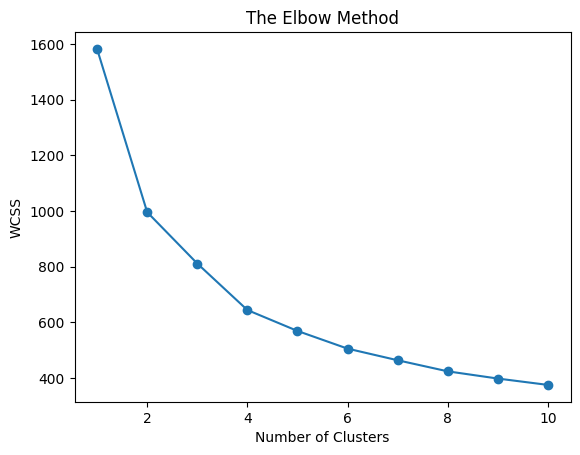

In [7]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

De este grafo mostrando within-cluster sum of squares por numero de clusters, elbow e ve aproximadamente en n_cluster = 3 o 4. Asi que ahora vamos a hacer KMeans con n=3 y con n=4

In [8]:
kmeans_3 = KMeans(n_clusters=3, init="k-means++", max_iter=300, n_init=10, random_state=42)
labels_3 = kmeans_3.fit_predict(df_scaled)

kmeans_4 = KMeans(n_clusters=4, init="k-means++", max_iter=300, n_init=10, random_state=42)
labels_4 = kmeans_4.fit_predict(df_scaled)

Ahora haciendo silhouette score para ver cual de los dos esta mejor (n=3 o n=4)

In [9]:
from sklearn.metrics import silhouette_score

# Compute silhouette score for both cases
silhouette_3 = silhouette_score(df_scaled, labels_3)
silhouette_4 = silhouette_score(df_scaled, labels_4)

print(f"Silhouette Score for 3 Clusters: {silhouette_3:.3f}")
print(f"Silhouette Score for 4 Clusters: {silhouette_4:.3f}")

Silhouette Score for 3 Clusters: 0.531
Silhouette Score for 4 Clusters: 0.370


In [10]:
#elegir  que esta mas alta y eso seria numero de clusters

In [11]:
# Nearest neighbours?

In [12]:
df_numeric.loc[:, "cluster_3"] = labels_3

C:\Users\Jordi\AppData\Local\Temp\ipykernel_13968\1428604759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric.loc[:, "cluster_3"] = labels_3


In [13]:
df_numeric["cluster_3"].value_counts()

cluster_3
1    234301
0     44340
2      8922
Name: count, dtype: int64

In [14]:
df_numeric.groupby("cluster_3").mean()

,meneos,clicks,karma,positive_votes,negative_votes,anonymous_votes,comments
cluster_3,,,,,,,
0,1211.928259,4785.819734,543.691069,401.089220,5.494587,810.839039,108.159720
1,377.836087,3072.752267,508.405756,172.364382,2.705699,205.471705,65.244916
2,669.724053,6494.435553,469.830868,261.586416,41.574535,408.137637,144.302623


In [15]:
# cluster 0 es menos numeroso
# media mas alta de clicks, muchos anonymous_votes y comments, y el grupo con mayor votos negativos

# cluster 1 es el más numeroso
# menor número de meneos y clicks, karma medio, positive_votes y negative_votes más bajos, menor número de comentarios

# cluster 2
# meneos más alto, clicks medios, karma, positive_votes y anonymous_votes más altos, y bastantes comments

In [16]:
# Cluster 0 → Noticias polémicas o virales con gran interacción
# Cluster 0 parece representar noticias polémicas, generando muchos clicks, comentarios y votos negativos

# Cluster 1 → Noticias estándar, sin ser virales ni polémicas.
# Cluster 1 es el comportamiento estándar de la mayoría de las noticias

# Cluster 2 → Noticias muy populares en la comunidad con alto impacto
# Cluster 2 agrupa noticias muy populares en la comunidad, con muchos meneos y karma alto

In [17]:
df_clustering.loc[:, "cluster_3"] = labels_3

C:\Users\Jordi\AppData\Local\Temp\ipykernel_13968\3181467307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering.loc[:, "cluster_3"] = labels_3


In [18]:
df_clustering.head()

,news_id,meneos,clicks,karma,positive_votes,negative_votes,anonymous_votes,comments,category,cluster_3
0,4032594,115,651,410,57,1,58,30,Política y Sociedad,1
1,4032568,77,982,362,50,2,27,24,Entretenimiento y Cultura,1
2,4032569,97,761,369,50,0,47,70,Política y Sociedad,1
3,4032482,141,505,352,77,1,64,53,Política y Sociedad,1
4,4032509,213,335,349,99,1,114,28,Política y Sociedad,1


In [21]:
chunk_size = 100000
num_chunks = (len(df_clustering) // chunk_size) + 1

for i in range(num_chunks):
    start_row = i * chunk_size
    end_row = start_row + chunk_size
    df_chunk = df_clustering.iloc[start_row:end_row]

    file_name = f"../00.data/clustering/df_clustering_{i+1}.pkl"
    with open(file_name, "wb") as f:
        pickle.dump(df_chunk, f, protocol=pickle.HIGHEST_PROTOCOL)

    print(f"Guardado: {file_name} con {len(df_chunk)} filas")

Guardado: ../00.data/clustering/df_clustering_1.pkl con 100000 filas
Guardado: ../00.data/clustering/df_clustering_2.pkl con 100000 filas
Guardado: ../00.data/clustering/df_clustering_3.pkl con 87563 filas


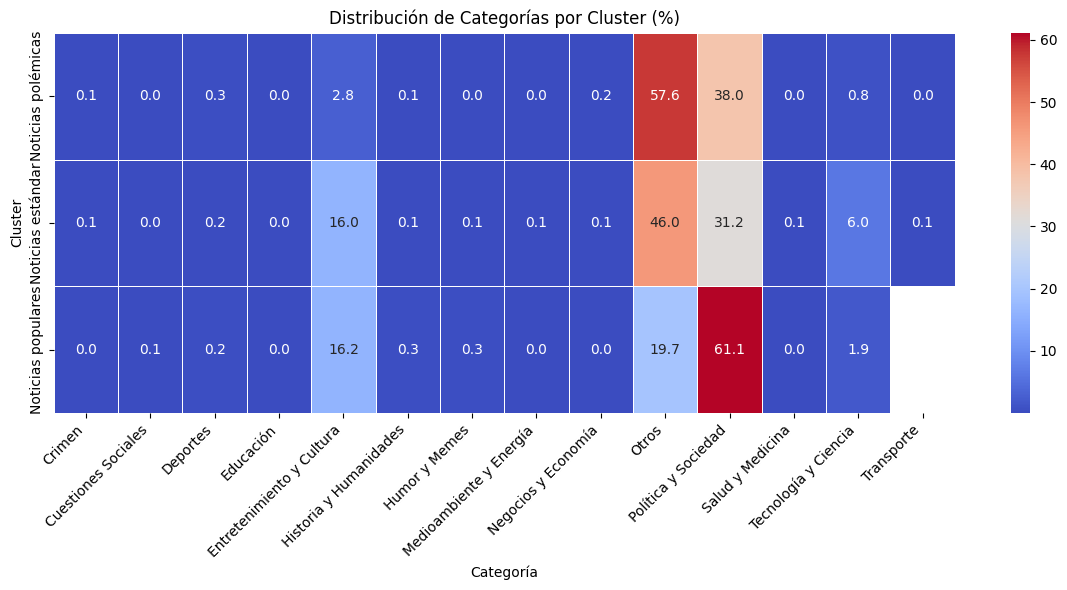

In [22]:
# Definir nombres de los clusters
cluster_names = {
    0: "Noticias polémicas",
    1: "Noticias estándar",
    2: "Noticias populares"
}

# Contar cuántas noticias de cada categoría hay en cada cluster
cluster_category_counts = df_numeric.join(df['category']).groupby(["cluster_3", "category"], observed=True).size().unstack()

# Normalizar por filas para ver proporciones en cada cluster
cluster_category_pct = cluster_category_counts.div(cluster_category_counts.sum(axis=1), axis=0) * 100

# Renombrar los índices de los clusters
cluster_category_pct.index = cluster_category_pct.index.map(cluster_names)

# Gráfico de calor para visualizar la distribución
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_category_pct, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)

plt.title("Distribución de Categorías por Cluster (%)")
plt.ylabel("Cluster")
plt.xlabel("Categoría")
plt.xticks(rotation=45, ha="right", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
## añadir mapa agrupado por category en vez de cluster

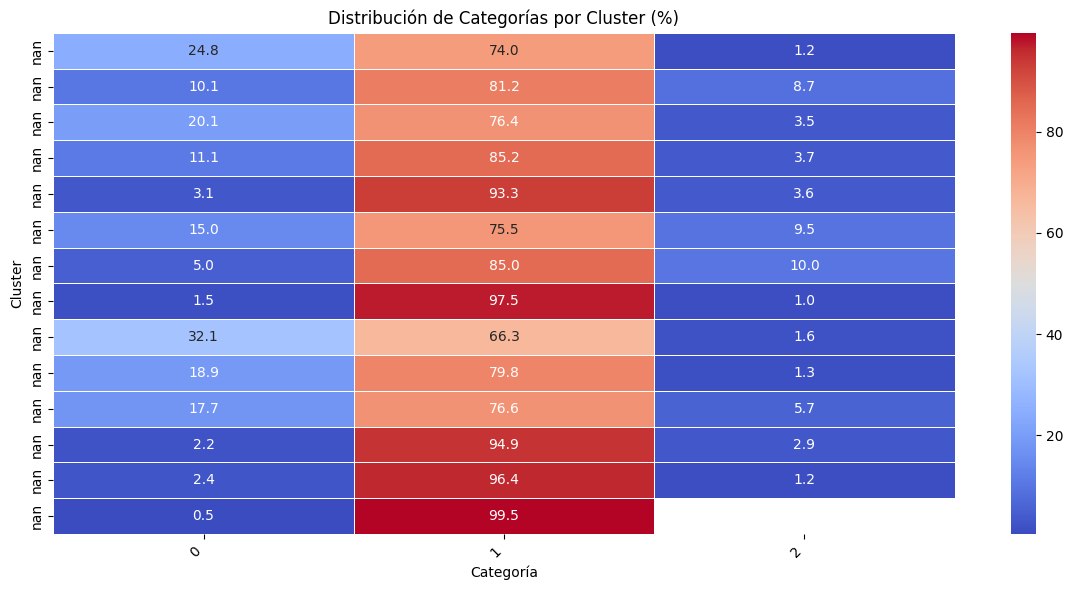

In [23]:
# Definir nombres de los clusters
cluster_names = {
    0: "Noticias polémicas",
    1: "Noticias estándar",
    2: "Noticias populares"
}

# Contar cuántas noticias de cada categoría hay en cada cluster
cluster_category_counts = df_numeric.join(df['category']).groupby(["category", "cluster_3"], observed=True).size().unstack()

# Normalizar por filas para ver proporciones en cada cluster
cluster_category_pct = cluster_category_counts.div(cluster_category_counts.sum(axis=1), axis=0) * 100

# Renombrar los índices de los clusters
cluster_category_pct.index = cluster_category_pct.index.map(cluster_names)

# Gráfico de calor para visualizar la distribución
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_category_pct, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)

plt.title("Distribución de Categorías por Cluster (%)")
plt.ylabel("Cluster")
plt.xlabel("Categoría")
plt.xticks(rotation=45, ha="right", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reducimos a 2 dimensiones con PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Convertimos a DataFrame para graficar
df_plot = pd.DataFrame(df_pca, columns=["PC1", "PC2"])
df_plot["Cluster"] = pd.Series(labels_3).map(cluster_names)

# Gráfico de dispersión con nombres personalizados
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="Cluster", palette="Set1", alpha=0.5)
plt.title("Visualización de Clusters (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()